In [1]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from Aux2 import *
import NMRAux as nmr
import Layers as ly

from torchinfo import summary

import torch as th
import torch.nn as nn
from torch import Tensor
from torch.utils.data import Dataset,DataLoader
from safetensors.torch import load_model
#from torchvision.models import googlenet

#from collections.abc import Callable
from tqdm.notebook import trange, tqdm

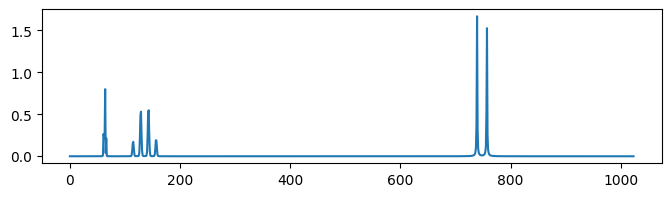

In [20]:
yy, res = nmr.generateRandomSpectrum()
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(yy["filtered"])
#ax.scatter(res,[yy["pure"][i] for i in res], c = "orange", zorder = 10)

In [3]:
ML = 10000
ML_test = 500
batch_size = 1
train_set = NMRDataset(maxLen = ML, mode = "wide")
test_set = NMRDataset(maxLen = ML_test, startSeed = ML)

train_loader: DataLoader = DataLoader(
    dataset=train_set, batch_size=batch_size, shuffle=False,
    num_workers=2
)
test_loader: DataLoader = DataLoader(
    dataset=test_set,  batch_size=batch_size, shuffle=False,
    num_workers=2
)

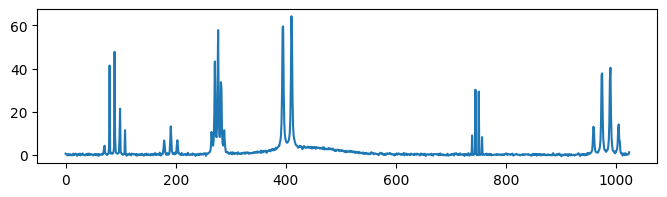

In [4]:
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(train_set[0][0].T)

In [6]:
model: th.nn.Module = NMRSeq().to(device)
summary(model, input_size=(batch_size,1,nmr.nPts))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 1, 1024]              --
├─Inception_variant: 1-1                 [1, 136, 1024]            --
│    └─Inception_piece: 2-1              [1, 16, 1024]             --
│    │    └─Conv1d: 3-1                  [1, 1, 1025]              3
│    │    └─Conv1d: 3-2                  [1, 16, 1024]             48
│    └─Inception_piece: 2-2              [1, 32, 1024]             --
│    │    └─Conv1d: 3-3                  [1, 1, 1027]              5
│    │    └─Conv1d: 3-4                  [1, 32, 1024]             160
│    └─Inception_piece: 2-3              [1, 64, 1024]             --
│    │    └─Conv1d: 3-5                  [1, 1, 1031]              9
│    │    └─Conv1d: 3-6                  [1, 64, 1024]             576
│    └─Inception_piece: 2-4              [1, 16, 1024]             --
│    │    └─Conv1d: 3-7                  [1, 1, 1055]              33
│    │    └─Conv

In [7]:
optimizer: th.optim.Optimizer = th.optim.Adam(
    params=model.parameters(), lr=0.001, weight_decay=0
)

#lossCriterion = nn.MSELoss()
lossCriterion = nn.CrossEntropyLoss()

In [9]:
load_model(model, "./modelpars2.safetensors")

(set(), set())

In [20]:
dataiter = train_loader.__iter__()
x_a, y_a = dataiter.__next__()

In [21]:
x_a, y_a = x_a.to(device), y_a.to(device)
target = model(x_a)
k = target.detach().numpy()[0][0]

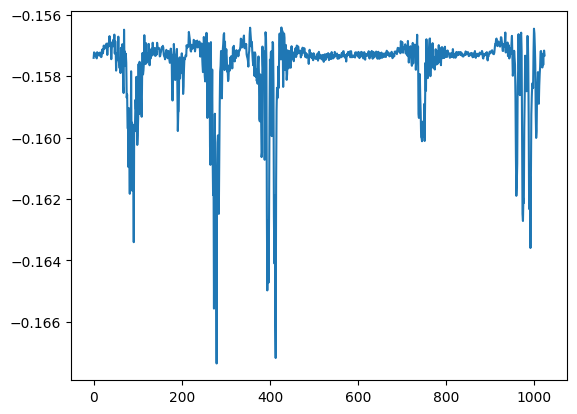

In [22]:
plt.plot(k)

In [16]:
train_set[0][1]

array([[0., 0., 0., ..., 0., 0., 0.]], shape=(1, 1024))